In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,log_loss
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns 


In [19]:
np.random.seed(42)
(train_pool_X, train_pool_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()
train_X, Pool_X, train_y,  Pool_y = train_test_split(train_pool_X, train_pool_y, train_size=50, random_state=42)
print(train_X.shape, Pool_X.shape, train_y.shape, Pool_y.shape, test_X.shape, test_y.shape)


(50, 28, 28) (59950, 28, 28) (50,) (59950,) (10000, 28, 28) (10000,)


In [20]:
train_pool_X = train_pool_X.reshape(train_pool_X.shape[0], -1)
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
Pool_X = Pool_X.reshape(Pool_X.shape[0], -1)
print(train_pool_X.shape, train_X.shape, test_X.shape, Pool_X.shape)

(60000, 784) (50, 784) (10000, 784) (59950, 784)


In [21]:
model = RandomForestClassifier()


Accuracy:  0.6109


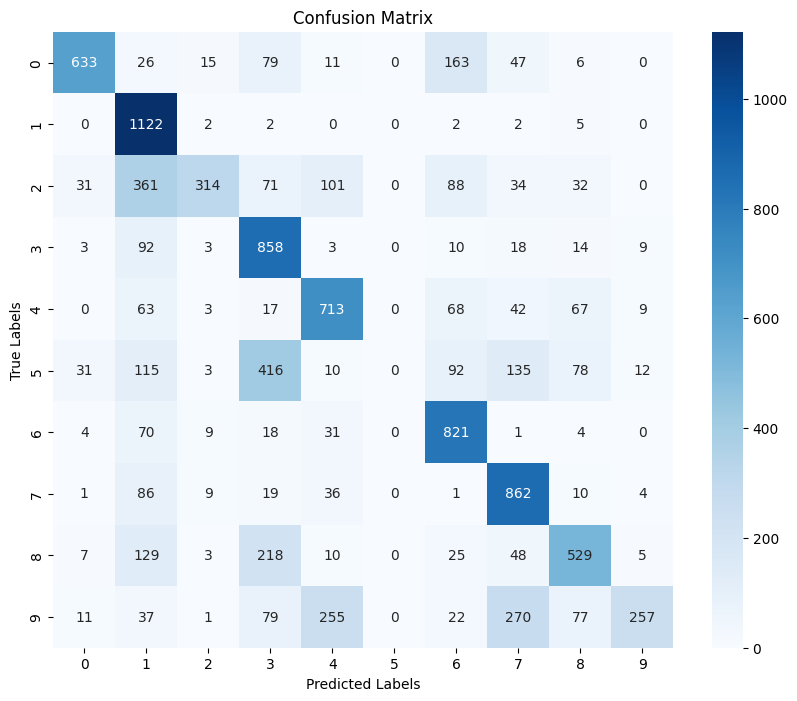

In [22]:
model.fit(train_X, train_y)
y_pred=model.predict(test_X)
print("Accuracy: ", accuracy_score(test_y, y_pred))
cm= confusion_matrix(test_y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels');

In [23]:
def add_random_samples(train_X, train_y, pool_X_train, pool_y_train, number_of_sample=1):
    random_indices = np.random.choice(pool_X_train.shape[0], size=number_of_sample, replace=False)
    labeled_X = pool_X_train[random_indices]
    labeled_y = pool_y_train[random_indices]

    train_X = np.concatenate((train_X, labeled_X), axis=0)
    train_y = np.concatenate((train_y, labeled_y), axis=0)
    pool_X_train = np.delete(pool_X_train, random_indices, axis=0)
    pool_y_train = np.delete(pool_y_train, random_indices)

    return train_X, train_y, pool_X_train, pool_y_train

In [24]:
def active_learning_random_sampling(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test,num_iterations=10, number_of_sample=1):
    accuracy_iteration = []

    for _ in range(num_iterations):
        model = RandomForestClassifier()
        train_X, train_y, pool_X_train, pool_y_train = add_random_samples(train_X, train_y, pool_X_train, pool_y_train, number_of_sample)

        model.fit(train_X, train_y)
        y_pred = model.predict(pool_X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy score after iteration {}: {:.4f} ".format(_ + 1, accuracy))

        accuracy_iteration.append(accuracy)

    return accuracy_iteration

In [25]:
accuracy_after_random_sampling = active_learning_random_sampling(train_X,train_y,Pool_X, Pool_y, test_X, test_y)

Accuracy score after iteration 1: 0.6128 
Accuracy score after iteration 2: 0.6151 
Accuracy score after iteration 3: 0.6019 
Accuracy score after iteration 4: 0.6073 
Accuracy score after iteration 5: 0.5989 
Accuracy score after iteration 6: 0.5891 
Accuracy score after iteration 7: 0.5936 
Accuracy score after iteration 8: 0.5931 
Accuracy score after iteration 9: 0.6012 
Accuracy score after iteration 10: 0.6044 


In [26]:
def entropy(p, epsilon=1e-7):
    p = np.clip(p, epsilon, 1.0 - epsilon)  
    return -np.sum(p * np.log2(p), axis=1)

In [27]:
def margin_sampling(probabilities):
    sorted_probs = np.sort(probabilities, axis=1)
    return sorted_probs[:, -1] - sorted_probs[:, -2]

In [28]:
def least_confident(probabilities):
    return 1 - np.max(probabilities, axis=1)

In [29]:

def active_learning(train_X, train_y, pool_X_train, pool_y_train, pool_X_test, y_test, acquisition_function, num_iterations=10, number_of_sample=1):
    accuracy_iteration = []

    for _ in range(num_iterations):
        model = RandomForestClassifier()
        model.fit(train_X, train_y)

        pool_probabilities = model.predict_proba(pool_X_train)
        acquisition_scores = acquisition_function(pool_probabilities)

        selected_indices = np.argsort(acquisition_scores)[-number_of_sample:]

        labeled_X = pool_X_train[selected_indices]
        labeled_y = pool_y_train[selected_indices]

        train_X = np.concatenate((train_X, labeled_X), axis=0)
        train_y = np.concatenate((train_y, labeled_y), axis=0)

        pool_X_train = np.delete(pool_X_train, selected_indices, axis=0)
        pool_y_train = np.delete(pool_y_train, selected_indices)
        
        y_pred = model.predict(pool_X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy score after iteration {}: {:.4f} ".format(_ + 1, accuracy))

        accuracy_iteration.append(accuracy)

    return  accuracy_iteration


In [30]:
accuracy_least_entropy = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y, acquisition_function=entropy,
                                                                                                 num_iterations=10,
                                                                                                 number_of_sample=1)

Accuracy score after iteration 1: 0.5995 
Accuracy score after iteration 2: 0.5991 
Accuracy score after iteration 3: 0.6002 
Accuracy score after iteration 4: 0.6353 
Accuracy score after iteration 5: 0.6061 
Accuracy score after iteration 6: 0.6286 
Accuracy score after iteration 7: 0.6321 
Accuracy score after iteration 8: 0.6145 
Accuracy score after iteration 9: 0.6464 
Accuracy score after iteration 10: 0.6267 


In [31]:
accuracy_least_margin = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,acquisition_function=margin_sampling,
                                                                                                 num_iterations=10,
                                                                                                 number_of_sample=1)

Accuracy score after iteration 1: 0.5841 
Accuracy score after iteration 2: 0.5923 
Accuracy score after iteration 3: 0.5817 
Accuracy score after iteration 4: 0.5824 
Accuracy score after iteration 5: 0.5978 
Accuracy score after iteration 6: 0.5918 
Accuracy score after iteration 7: 0.6011 
Accuracy score after iteration 8: 0.5980 
Accuracy score after iteration 9: 0.5800 
Accuracy score after iteration 10: 0.5685 


In [32]:
accuracy_confident = active_learning(train_X,train_y,Pool_X, Pool_y, test_X, test_y,acquisition_function=least_confident,
                                                                             num_iterations=10,
                                                                             number_of_sample=1)

Accuracy score after iteration 1: 0.5756 
Accuracy score after iteration 2: 0.6153 
Accuracy score after iteration 3: 0.6160 
Accuracy score after iteration 4: 0.6293 
Accuracy score after iteration 5: 0.6263 
Accuracy score after iteration 6: 0.6314 
Accuracy score after iteration 7: 0.6348 
Accuracy score after iteration 8: 0.6340 
Accuracy score after iteration 9: 0.6486 
Accuracy score after iteration 10: 0.6438 


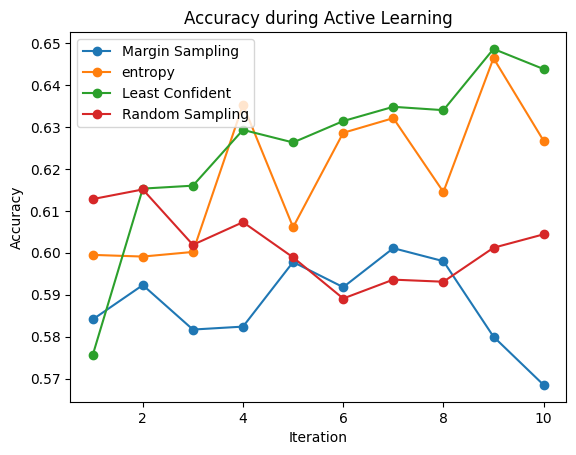

In [33]:
plt.plot(range(1, len(accuracy_least_margin) + 1), accuracy_least_margin, marker='o',label='Margin Sampling')
plt.plot(range(1, len(accuracy_least_entropy) + 1), accuracy_least_entropy,marker='o', label='entropy')
plt.plot(range(1, len(accuracy_confident) + 1), accuracy_confident, marker='o',label='Least Confident')
plt.plot(range(1, len(accuracy_after_random_sampling) + 1), accuracy_after_random_sampling, marker='o',label='Random Sampling')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy during Active Learning')
plt.legend();